In [2]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt

from scipy.sparse import hstack
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

In [11]:
from pycaret.classification import *

In [3]:
# A helper function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [4]:
path_train = '../input/catch_me_if_you_can/train_sessions.csv'
path_test = '../input/catch_me_if_you_can/test_sessions.csv'
df_train = pd.read_csv(path_train, index_col='session_id')
df_test = pd.read_csv(path_test, index_col='session_id')

# df_train = df_train.sort_values(by='time1')
sites = [f'site{i}' for i in range(1, 11)]
times = [f'time{i}' for i in range(1, 11)]

In [5]:
def df_preprocessing(df, ss=None):
    df['num_of_sites'] = df[sites].notna().sum(axis=1)
    for time in times:
        df[time] = pd.to_datetime(df[time])
    
    df['t_0'] = df[times].min(axis=1)
    df['t_f'] = df[times].max(axis=1)
    df['month'] = df['t_0'].dt.month.astype('category')
    df['weekday'] = df['t_0'].dt.dayofweek.astype('category')
    df['start_hour'] = df['t_0'].dt.hour.astype('category')
    df['start_day'] = df['t_0'].dt.day.astype('category')
    df['log_t_len'] = np.log((df['t_f'] - df['t_0']).dt.seconds.astype('float') + 1)
    
    flag_train = False
    if ss is None:
        flag_train = True
        ss = StandardScaler()
        df['log_t_len'] = ss.fit_transform(df['log_t_len'].values.reshape(-1,1))
    else:
        df['log_t_len'] = ss.transform(df['log_t_len'].values.reshape(-1,1))

    df = df.reset_index(drop=True)
    df = df.drop(sites + times + ['t_0', 't_f'], axis=1)

    if flag_train:
        return df, ss
    else:
        return df
        

In [6]:
df_train, ss = df_preprocessing(df_train)
df_test = df_preprocessing(df_test, ss)
# pd.DataFrame(df_train['t_len']).profile_report()
df_train

,target,num_of_sites,month,weekday,start_hour,start_day,log_t_len
0,0,1,2,3,10,20,-1.907994
1,0,10,2,5,11,22,-0.073098
2,0,10,12,0,16,16,-0.750303
3,0,10,3,4,10,28,1.210882
4,0,10,2,4,10,28,1.159256
...,...,...,...,...,...,...,...
253556,0,10,11,0,10,25,0.371457
253557,0,10,3,1,16,12,-1.136200
253558,0,5,9,3,14,12,0.584681
253559,0,10,12,3,15,19,-1.296362


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253561 entries, 0 to 253560
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   target        253561 non-null  int64   
 1   num_of_sites  253561 non-null  int64   
 2   month         253561 non-null  category
 3   weekday       253561 non-null  category
 4   start_hour    253561 non-null  category
 5   start_day     253561 non-null  category
 6   log_t_len     253561 non-null  float64 
dtypes: category(4), float64(1), int64(2)
memory usage: 6.8 MB


In [9]:
# df_train[:300].profile_report()

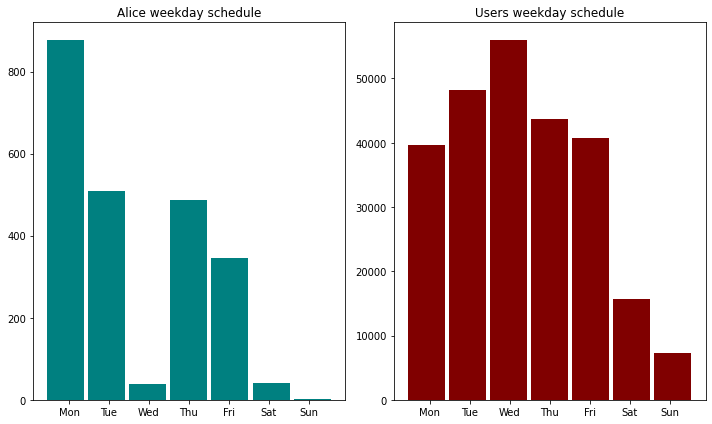

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].hist(df_train[df_train.target==1].weekday, bins=7, color='teal', label='Alice', rwidth=0.9)
ax[1].hist(df_train[df_train.target==0].weekday, bins=7, color='maroon', label='Users', rwidth=0.9)
ax[0].set_xticks(ticks=[i - 0.5 for i in np.linspace(1,6,7)])
ax[1].set_xticks(ticks=[i - 0.5 for i in np.linspace(1,6,7)])
ax[0].set_xticklabels(labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax[1].set_xticklabels(labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax[0].title.set_text('Alice weekday schedule')
ax[1].title.set_text('Users weekday schedule')
plt.tight_layout()
plt.show()

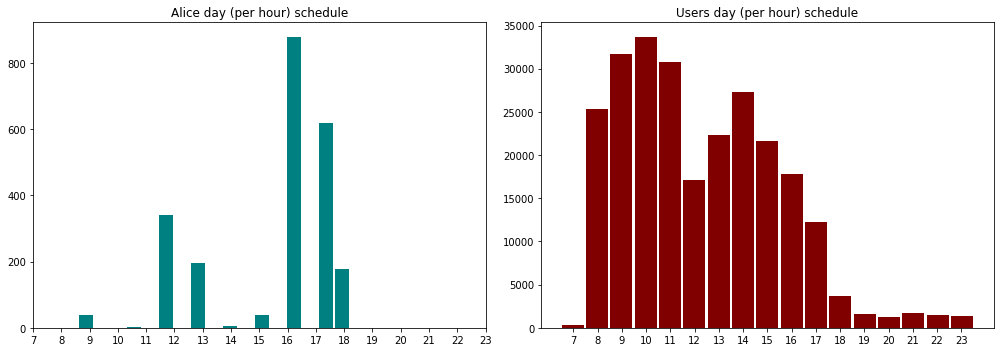

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].hist(df_train[df_train.target==1].start_hour, bins=17, color='teal', label='Alice', rwidth=0.9)
ax[1].hist(df_train[df_train.target==0].start_hour, bins=17, color='maroon', label='Users', rwidth=0.9)
ax[0].set_xticks(ticks=[i + 0.5 for i in np.linspace(7,22,17)])
ax[1].set_xticks(ticks=[i + 0.5 for i in np.linspace(7,22,17)])
ax[0].set_xticklabels(labels=[str(i) for i in range(7, 24)])
ax[1].set_xticklabels(labels=['7','8' ,'9','10','11','12','13','14','15','16','17',
                   '18','19','20','21','22','23'])
ax[0].title.set_text('Alice day (per hour) schedule')
ax[1].title.set_text('Users day (per hour) schedule')
plt.tight_layout()
plt.show()

In [31]:
pd.DataFrame(df_train[df_train.target==1].groupby('start_hour')['target'].mean())

,target
start_hour,
7,NaN
8,NaN
9,1.0
10,NaN
11,1.0
12,1.0
13,1.0
14,1.0
15,1.0


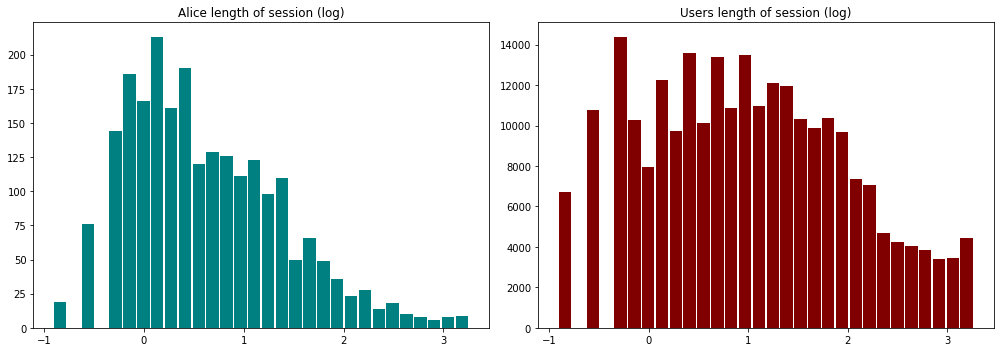

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].hist((df_train[df_train.target==1].log_t_len + 1), bins=30, color='teal', label='Alice', rwidth=0.9)
ax[1].hist((df_train[df_train.target==0].log_t_len + 1), bins=30, color='maroon', label='Users', rwidth=0.9)
ax[0].title.set_text('Alice length of session (log)')
ax[1].title.set_text('Users length of session (log)')
plt.tight_layout()
plt.show()

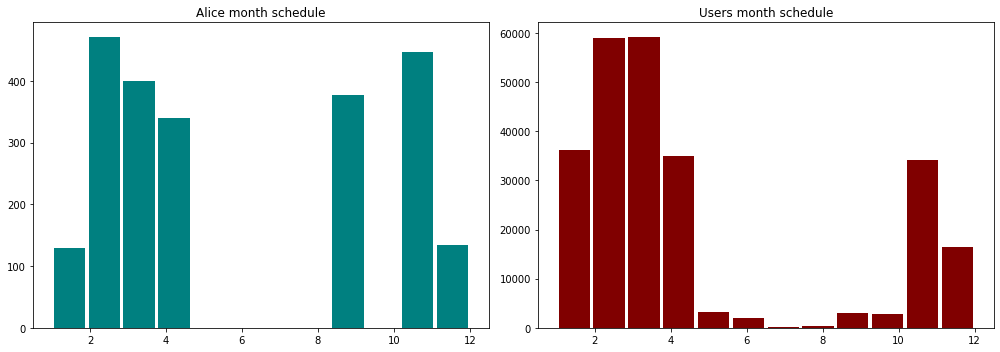

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].hist(df_train[df_train.target==1].month, bins=12, color='teal', label='Alice', rwidth=0.9)
ax[1].hist(df_train[df_train.target==0].month, bins=12, color='maroon', label='Users', rwidth=0.9)
ax[0].title.set_text('Alice month schedule')
ax[1].title.set_text('Users month schedule')
plt.tight_layout()
plt.show()

In [10]:
time_split = TimeSeriesSplit(n_splits=10)
xgb = XGBClassifier()

In [20]:
caret_exp = setup(df_train, target='target', use_gpu=True)

,Description,Value
0,session_id,5709
1,Target,target
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(253561, 7)"
5,Missing Values,False
6,Numeric Features,1
7,Categorical Features,5
8,Ordinal Features,False
9,High Cardinality Features,False


In [21]:
# top5_models = compare_models(fold=5, round=3, sort='AUC', n_select=3)
top5_models = compare_models(fold=time_split, round=3, sort='AUC', n_select=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.991,0.981,0.205,0.552,0.294,0.291,0.329,0.587
lightgbm,Light Gradient Boosting Machine,0.991,0.979,0.245,0.507,0.327,0.323,0.346,1.305
gbc,Gradient Boosting Classifier,0.991,0.959,0.143,0.630,0.230,0.228,0.294,8.857
ada,Ada Boost Classifier,0.991,0.953,0.000,0.000,0.000,-0.000,-0.001,2.158
lr,Logistic Regression,0.991,0.951,0.000,0.000,0.000,0.000,0.000,0.859
lda,Linear Discriminant Analysis,0.980,0.916,0.253,0.153,0.190,0.181,0.187,0.793
rf,Random Forest Classifier,0.989,0.897,0.327,0.396,0.357,0.352,0.354,1.779
knn,K Neighbors Classifier,0.991,0.867,0.280,0.474,0.351,0.346,0.359,8.781
nb,Naive Bayes,0.636,0.811,0.983,0.024,0.047,0.030,0.121,0.098
et,Extra Trees Classifier,0.989,0.788,0.310,0.392,0.344,0.338,0.342,2.035


In [22]:
top5_models_tuned = [tune_model(model) for model in top5_models]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9913,0.9816,0.1667,0.5745,0.2584,0.2553,0.3063
1,0.9918,0.9903,0.1852,0.6977,0.2927,0.2900,0.3568
2,0.9908,0.9847,0.2360,0.4810,0.3167,0.3126,0.3328
3,0.9911,0.9814,0.2050,0.5238,0.2946,0.2910,0.3240
4,0.9914,0.9717,0.2174,0.5738,0.3153,0.3119,0.3498
5,0.9910,0.9858,0.1801,0.5179,0.2673,0.2638,0.3019
6,0.9906,0.9791,0.1677,0.4576,0.2455,0.2418,0.2732
7,0.9915,0.9790,0.2360,0.5758,0.3348,0.3313,0.3652
8,0.9900,0.9760,0.1677,0.3857,0.2338,0.2295,0.2500


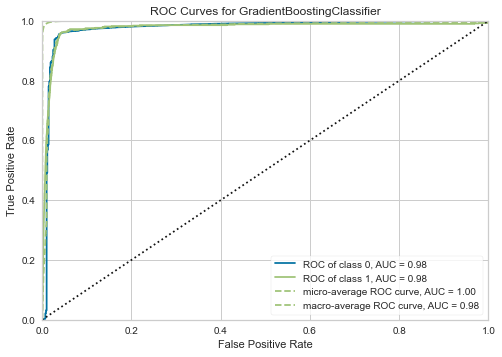

In [23]:
for model in top5_models_tuned:
    plot_model(model, plot='auc')

In [80]:
X_train = df_train.drop('target', axis=1)
y_train = df_train['target']
X_test = df_test

In [81]:
import lightgbm as lgb

lgbc = lgb.LGBMClassifier(random_state=42)
lgbc.fit(X_train, y_train)

LGBMClassifier(random_state=42)

In [88]:
# cv_scores = cross_val_score(lgbc, X_train, y_train, cv=time_split, scoring='roc_auc', n_jobs=-1)
cv_scores = cross_val_score(lgbc, X_train, y_train, cv=10, scoring='roc_auc', n_jobs=-1)
cv_scores

array([0.98821059, 0.98626879, 0.98894489, 0.98821732, 0.98111077,
       0.98812853, 0.98589241, 0.98568796, 0.98704451, 0.98370006])

In [83]:
lgbc_test_pred = lgbc.predict_proba(X_test)[:, 1]
write_to_submission_file(lgbc_test_pred, '../output/submit_catch_me_lgbc.csv')

In [84]:
logit = LogisticRegression(C=1, random_state=17, solver='liblinear')
logit.fit(X_train, y_train)

LogisticRegression(C=1, random_state=17, solver='liblinear')

In [85]:
cv_scores = cross_val_score(logit, X_train, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=-1) # hangs with n_jobs > 1, and locally this runs much faster

In [86]:
cv_scores, cv_scores.mean()

(array([0.82995707, 0.8481771 , 0.85469676, 0.81846801, 0.84729978,
        0.84616857, 0.84752183, 0.80598487, 0.8269534 , 0.83007842]),
 0.8355305810419923)

In [87]:
logit_test_pred = logit.predict_proba(X_test)[:, 1]
write_to_submission_file(logit_test_pred, '../output/submit_catch_me_logit.csv')